In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from anomaly_detection.data.data_loader import EELSDataset, get_data_loader
from anomaly_detection.config.config_handler import get_config
import numpy as np
from sklearn.metrics import roc_auc_score

# Load configuration
config = get_config("/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml")

# Get DataLoader
train_loader = get_data_loader(config)

# Define the VAE model
class ComplexVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ComplexVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3)),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2)),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6 * 30, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256 * 6 * 6 * 30),
            nn.ReLU(),
            nn.Unflatten(1, (256, 6, 6, 30)),
            nn.ConvTranspose3d(256, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2), output_padding=(0,0,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3), output_padding=(0,0,1))
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return h[:, :self.latent_dim], h[:, self.latent_dim:]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the Dictionary Learning component
class DictionaryLearning(nn.Module):
    def __init__(self, latent_dim, dict_size):
        super(DictionaryLearning, self).__init__()
        self.dictionary = nn.Parameter(torch.randn(latent_dim, dict_size))
        self.sparse_codes = nn.Parameter(torch.zeros(dict_size, 1))
    
    def forward(self, z):
        return torch.mm(self.dictionary, self.sparse_codes).squeeze()

# Combine VAE and Dictionary Learning
class VAEWithDictionary(nn.Module):
    def __init__(self, latent_dim, dict_size):
        super(VAEWithDictionary, self).__init__()
        self.vae = ComplexVAE(latent_dim)
        self.dict_learning = DictionaryLearning(latent_dim, dict_size)
    
    def forward(self, x):
        recon_x, mu, logvar = self.vae(x)
        z = self.vae.reparameterize(mu, logvar)
        dict_recon = self.dict_learning(z)
        return recon_x, mu, logvar, z, dict_recon

# Loss function
def loss_function(recon_x, x, mu, logvar, z, dict_recon, lambda1=1.0, lambda2=0.2):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    dict_loss = torch.sum((z - dict_recon).pow(2))
    sparse_loss = torch.sum(torch.abs(model.dict_learning.sparse_codes))
    return MSE + KLD + lambda1 * dict_loss + lambda2 * sparse_loss, MSE

# Anomaly detection function
def anomaly_score(model, x):
    with torch.no_grad():
        _, mu, logvar, z, dict_recon = model(x)
        return torch.sum((z - dict_recon).pow(2), dim=1)

# Training function
def train(model, train_loader, optimizer, device, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z, dict_recon = model(data)
            loss, MSE = loss_function(recon_batch, data, mu, logvar, z, dict_recon)
            loss.backward()
            optimizer.step()
            
            # Normalize dictionary atoms
            with torch.no_grad():
                model.dict_learning.dictionary.data = nn.functional.normalize(model.dict_learning.dictionary.data, dim=0)
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Average loss: {total_loss / len(train_loader.dataset):.4f}, MSE: {MSE}')

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)


In [3]:
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 20
dict_size = 20
num_epochs = 150
learning_rate = 1e-4

model = VAEWithDictionary(latent_dim, dict_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, optimizer, device, num_epochs)

# Save the trained model
# torch.save(model.state_dict(), 'vae_dictionary_model.pth')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x285696 and 276480x512)

In [1]:
model.eval()

# Load configuration and get a batch of normal data
train_loader = get_data_loader(config)
normal_batch = next(iter(train_loader))

def inject_anomalies(image, num_clusters=1, cluster_size=5, shift_amount=40, noise_factor=0.1, peak_reduction_factor=0.2, peak_reduction_probability=0.3):
    """
    Inject anomalies into the EELS image with added noise and peak reduction options.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    num_clusters (int): Number of anomalous clusters to inject
    cluster_size (int): Size of each anomalous cluster
    shift_amount (int): Amount to shift the peak (in energy channels)
    noise_factor (float): Factor to control the amount of noise added (0 to 1)
    peak_reduction_factor (float): Factor to reduce peak intensity (0 to 1)
    peak_reduction_probability (float): Probability of applying peak reduction to a cluster (0 to 1)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
        anomalous_image (numpy.ndarray): Image with injected anomalies, noise, and peak reductions
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalous pixels
    """
    anomalous_image = np.copy(image)
    height, width, channels = image.shape
    anomaly_mask = np.zeros((height, width), dtype=bool)
    
    # Add global noise
    noise = np.random.normal(0, noise_factor * np.mean(image), image.shape)
    anomalous_image += noise
    
    for _ in range(num_clusters):
        # Choose a random center for the cluster
        center_y = np.random.randint(cluster_size, height - cluster_size)
        center_x = np.random.randint(cluster_size, width - cluster_size)
        
        # Define the cluster region
        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2 + 1
        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2 + 1
        
        # Mark the cluster region as anomalous
        anomaly_mask[y_start:y_end, x_start:x_end] = True
        
        # Shift the peak
        if np.random.random() < 0.5:  # 50% chance to shift left or right
            anomalous_image[y_start:y_end, x_start:x_end, :-shift_amount] = image[y_start:y_end, x_start:x_end, shift_amount:]
        else:
            anomalous_image[y_start:y_end, x_start:x_end, shift_amount:] = image[y_start:y_end, x_start:x_end, :-shift_amount]
        
        # Randomly reduce peak intensity
        if np.random.random() < peak_reduction_probability:
            peak_intensity = np.max(anomalous_image[y_start:y_end, x_start:x_end])
            reduction_amount = peak_intensity * peak_reduction_factor
            anomalous_image[y_start:y_end, x_start:x_end] -= reduction_amount
    
    # Ensure all values are non-negative
    anomalous_image = np.clip(anomalous_image, 0, None)
    
    return anomalous_image, anomaly_mask

# Function to create anomalous data
def create_anomalous_batch(normal_batch):
    anomalous_batch = []
    anomaly_masks = []
    for i in range(normal_batch.size(0)):  # Iterate over batch dimension
        normal_image = normal_batch[i, 0].cpu().numpy()  # Remove channel dimension
        anomalous_image, anomaly_mask = inject_anomalies(normal_image)
        anomalous_batch.append(anomalous_image)
        anomaly_masks.append(anomaly_mask)
    return np.array(anomalous_batch), np.array(anomaly_masks)

# Create anomalous data
anomalous_batch, anomaly_masks = create_anomalous_batch(normal_batch)

# Convert to torch tensors
anomalous_batch = torch.from_numpy(anomalous_batch).float().unsqueeze(1)  # Add channel dimension
normal_batch = normal_batch.float()

# Move to the same device as the model
device = next(model.parameters()).device
anomalous_batch = anomalous_batch.to(device)
normal_batch = normal_batch.to(device)

# Compute anomaly scores for both normal and anomalous data
with torch.no_grad():
    normal_scores = anomaly_score(model, normal_batch)
    anomalous_scores = anomaly_score(model, anomalous_batch)

# Convert scores to numpy for easier handling
normal_scores = normal_scores.cpu().numpy()
anomalous_scores = anomalous_scores.cpu().numpy()

print(normal_scores)
print(anomalous_scores)

# Compute threshold (e.g., 95th percentile of normal scores)
threshold = np.percentile(normal_scores, 50)

# Classify as anomaly if score is above threshold
normal_predictions = normal_scores > threshold
anomalous_predictions = anomalous_scores > threshold

# Print results
print(f"Normal data classified as anomaly: {normal_predictions.sum()}/{len(normal_predictions)}")
print(f"Anomalous data classified as anomaly: {anomalous_predictions.sum()}/{len(anomalous_predictions)}")

# Compute detection rate for anomalous data
detection_rate = anomalous_predictions.sum() / len(anomalous_predictions)
print(f"Anomaly detection rate: {detection_rate:.2%}")

# If you want to visualize the results, you can plot histograms of the scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(normal_scores, bins=50, alpha=0.5, label='Normal')
plt.hist(anomalous_scores, bins=50, alpha=0.5, label='Anomalous')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.show()

NameError: name 'model' is not defined

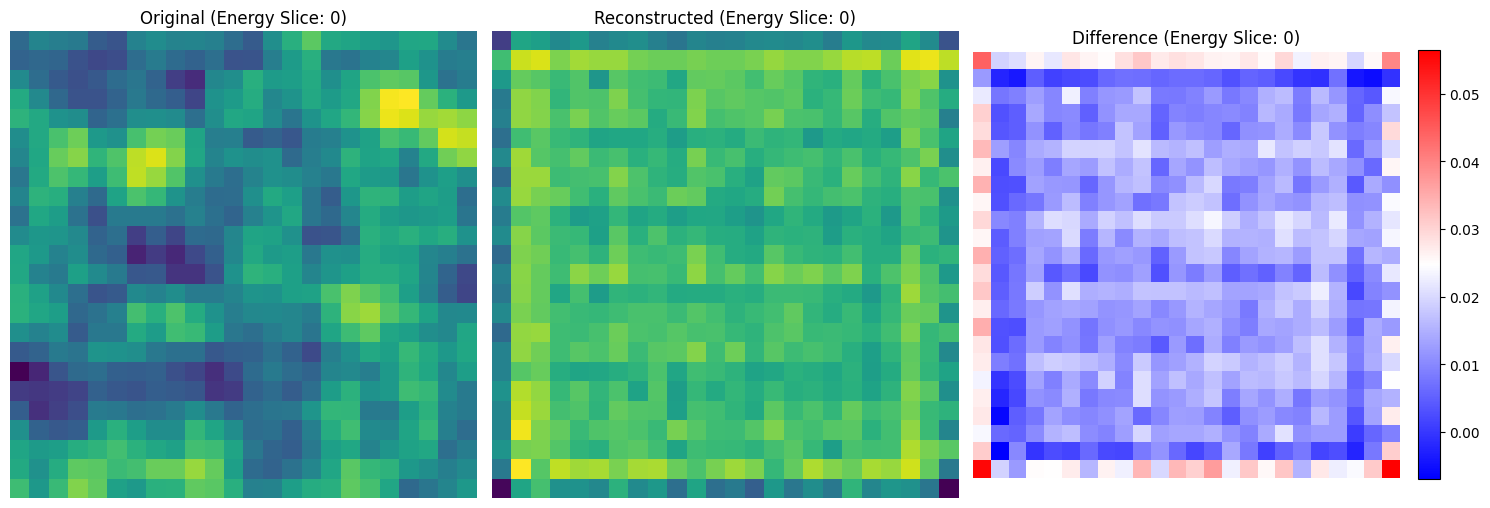

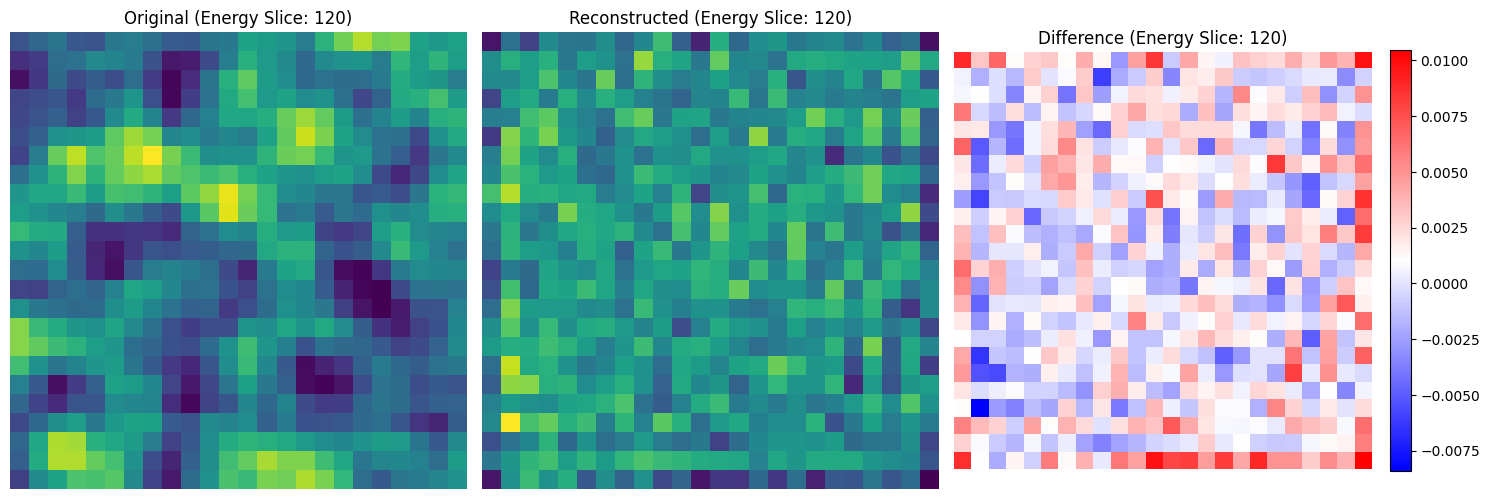

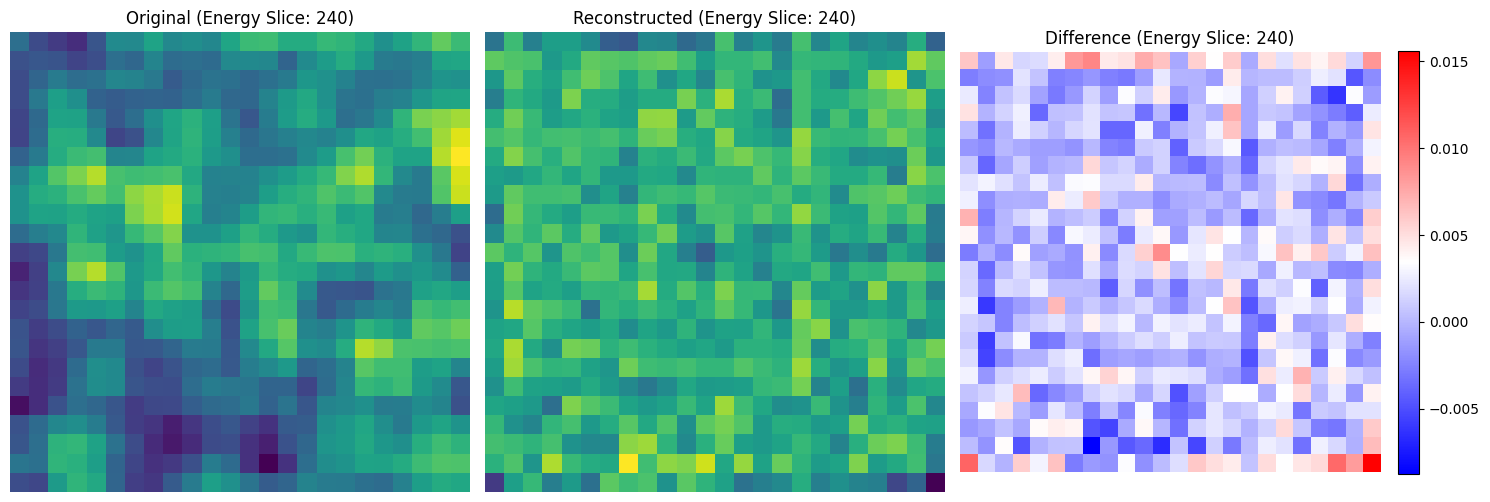

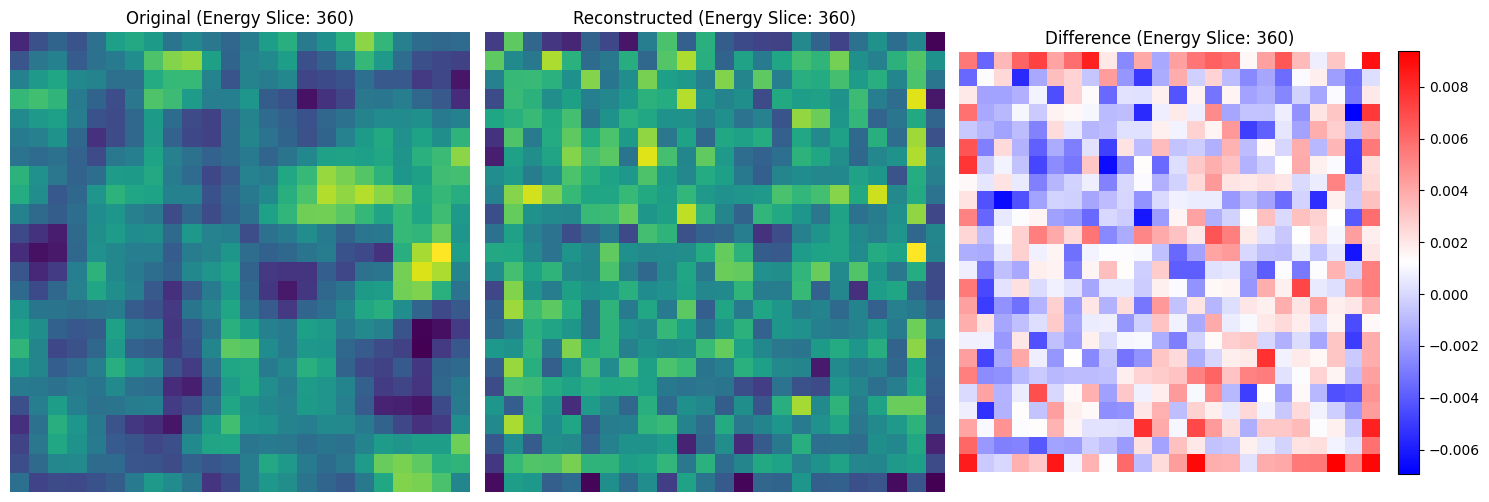

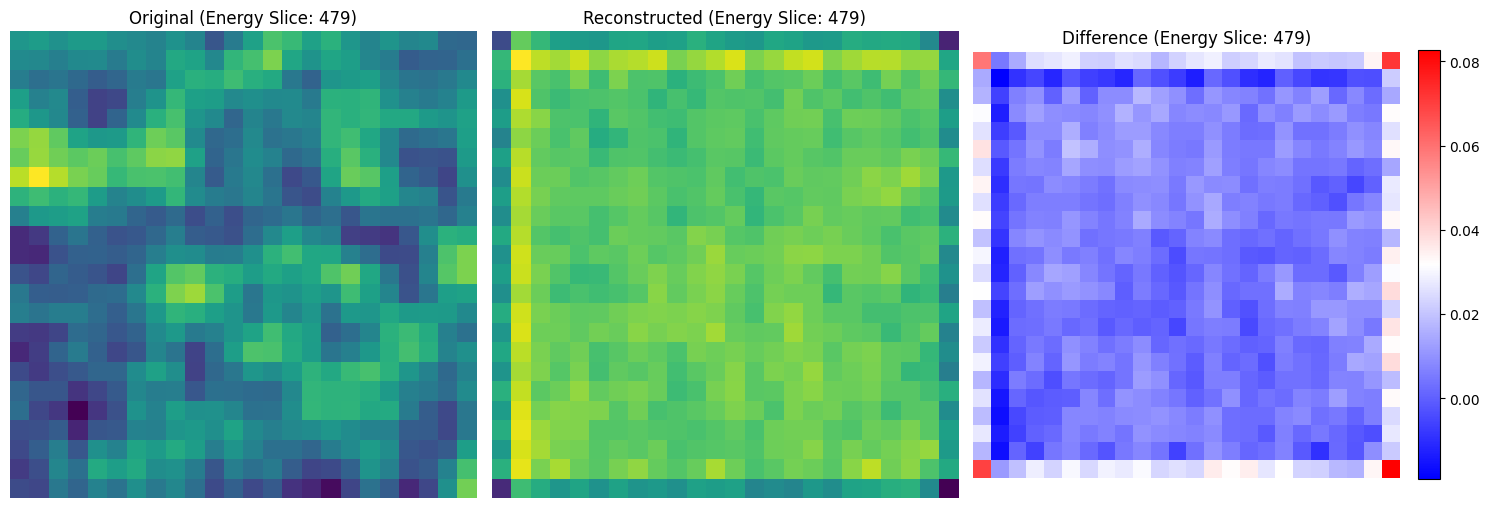

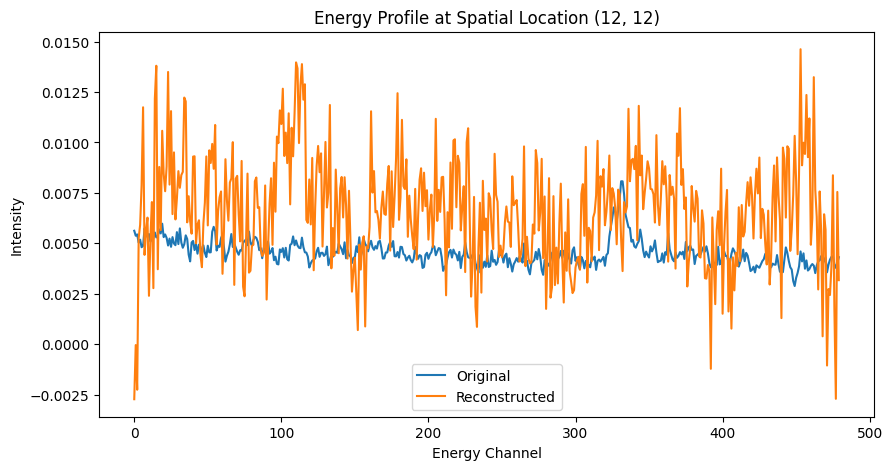

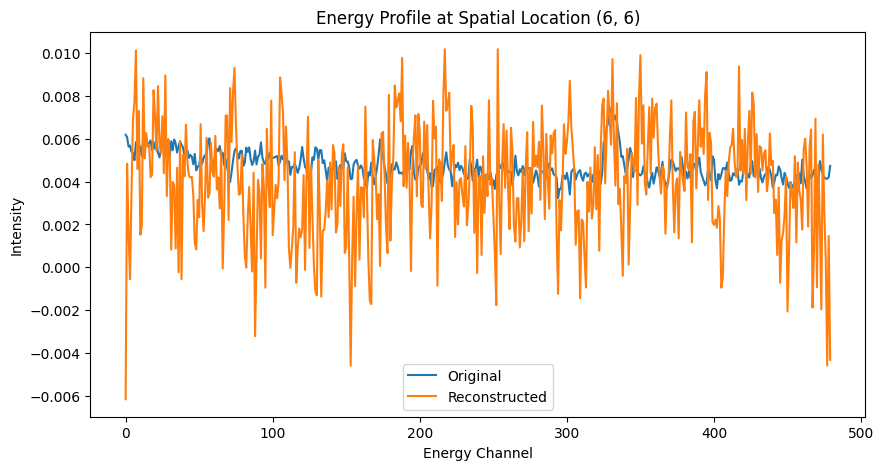

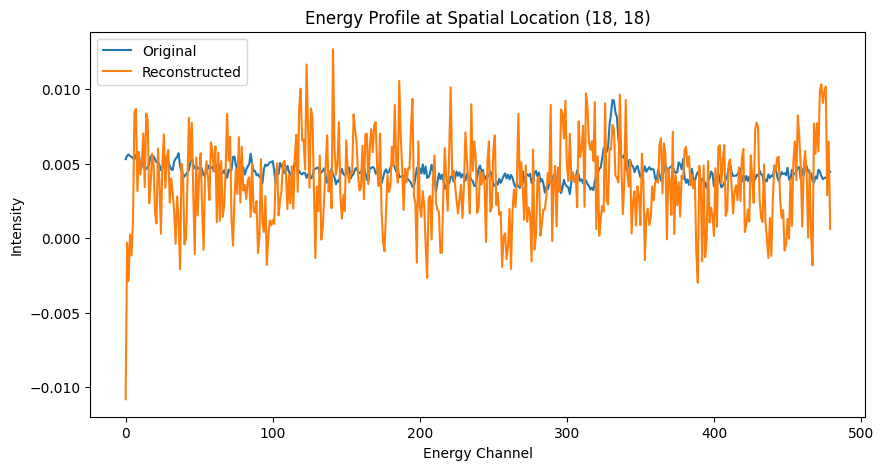

In [29]:
original_batch = next(iter(train_loader))

# Move data to the same device as the model
device = next(model.parameters()).device
original_batch = original_batch.to(device)

# Get the reconstruction
with torch.no_grad():
    reconstructed_batch, _, _, _, _ = model(original_batch)

# Move data back to CPU for plotting
original_batch = original_batch.cpu().numpy()
reconstructed_batch = reconstructed_batch.cpu().numpy()

# Function to plot original, reconstructed, and difference images
def plot_comparison(original, reconstructed, energy_slice, sample_index=0):
    diff = original - reconstructed
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original[sample_index, 0, :, :, energy_slice], cmap='viridis')
    axes[0].set_title(f'Original (Energy Slice: {energy_slice})')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed[sample_index, 0, :, :, energy_slice], cmap='viridis')
    axes[1].set_title(f'Reconstructed (Energy Slice: {energy_slice})')
    axes[1].axis('off')
    
    im = axes[2].imshow(diff[sample_index, 0, :, :, energy_slice], cmap='bwr')
    axes[2].set_title(f'Difference (Energy Slice: {energy_slice})')
    axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Plot comparisons for different energy slices
energy_slices = [0, 120, 240, 360, 479]  # Choose slices to visualize
for slice_index in energy_slices:
    plot_comparison(original_batch, reconstructed_batch, slice_index)

# Plot the energy profile for a specific spatial location
def plot_energy_profile(original, reconstructed, x, y, sample_index=0):
    original_profile = original[sample_index, 0, x, y, :]
    reconstructed_profile = reconstructed[sample_index, 0, x, y, :]
    
    plt.figure(figsize=(10, 5))
    plt.plot(original_profile, label='Original')
    plt.plot(reconstructed_profile, label='Reconstructed')
    plt.title(f'Energy Profile at Spatial Location ({x}, {y})')
    plt.xlabel('Energy Channel')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

# Plot energy profiles for a few spatial locations
spatial_locations = [(12, 12), (6, 6), (18, 18)]  # Choose locations to visualize
for x, y in spatial_locations:
    plot_energy_profile(original_batch, reconstructed_batch, x, y)